# 4. stitching of multi-tile images

In [1]:
import os
import time
from useq import MDAEvent, MDASequence, Position
from pymmcore_plus.mda import mda_listeners_connected
from pymmcore_plus.mda.handlers import ImageSequenceWriter
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import numpy as np
from scipy.optimize import curve_fit
import glob
import pandas as pd
import m2stitch
from os import path

# set micro manager directory
mm_dir = 'D:\ProgramFiles\Micro-Manager-2.0'

# load micro manager system configuration
from pymmcore_plus import CMMCorePlus, Device, DeviceAdapter, ConfigGroup
core = CMMCorePlus()
#core_plus.setDeviceAdapterSearchPaths([mm_dir])
core.loadSystemConfiguration(os.path.join(mm_dir, 'MMConfig_Edge42_SOLA_ASIStage_PixelSize.cfg'))

In [2]:
# set field of view size
f = 1192.8

### np.concatenate()

In [3]:
test_images = glob.glob(r'C:\Users\Admin\Desktop\test_files\*.png')
test_images

['C:\\Users\\Admin\\Desktop\\test_files\\00000_p000_g000_c00.png',
 'C:\\Users\\Admin\\Desktop\\test_files\\00001_p000_g001_c00.png',
 'C:\\Users\\Admin\\Desktop\\test_files\\00002_p000_g002_c00.png',
 'C:\\Users\\Admin\\Desktop\\test_files\\00003_p000_g003_c00.png']

In [4]:
a11 = cv2.imread(test_images[0])
a11.shape

(2048, 2048, 3)

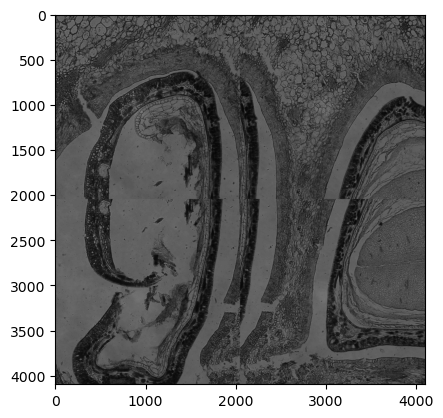

In [5]:
a11 = img.imread(rf'{test_images[3]}')
a12 = img.imread(rf'{test_images[2]}')
a21 = img.imread(rf'{test_images[1]}')
a22 = img.imread(rf'{test_images[0]}')
upper = np.concatenate((a11, a12), axis=1)
lower = np.concatenate((a21, a22), axis=1)
whole = np.concatenate((upper, lower), axis=0)
plt.imshow(whole, cmap='gray')

### 'stitching' -> does not work :(
https://github.com/OpenStitching/stitching

In [6]:
from stitching import Stitcher

stitcher = Stitcher(detector='orb', confidence_threshold=0.01)
image = stitcher.stitch([test_images[1], test_images[0]])

StitchingError: No match exceeds the given confidence threshold.
                                 Do your images have enough overlap and common
                                 features? If yes, you might want to lower the
                                 'confidence_threshold' or try another
                                 'detector'.

### 'microscopestitching' -> does not work :(
https://github.com/arve0/microscopestitching

In [7]:
from microscopestitching import stitch

path = r'C:\Users\Admin\Desktop\test_files'

images = [(path+r'\00003_p000_g003_c00.png', 0, 0), 
          (path+r'\00002_p000_g002_c00.png', 0, 1), 
          (path+r'\00001_p000_g001_c00.png', 1, 0), 
          (path+r'\00000_p000_g000_c00.png', 1, 1)
          ]

merged = stitch(images)

ValueError: too many values to unpack (expected 2)

### 'm2stitch' -> funktioniert :)))
https://github.com/yfukai/m2stitch
* Provides robust stitching of tiled microscope images on a regular grid, mostly following algorithm by MIST but improved in several points.
* Supports missing tiles.

In [8]:
import m2stitch

In [9]:
images = np.stack([a11, a12, a21, a22], axis=0)
images.shape

(4, 2048, 2048)

In [14]:
def flatten_rows(rows):
    r = []
    for xs in rows:
        for x in xs:
            r.append(x)
    return r

def flatten_cols(cols):
    c = np.concatenate(cols).ravel().tolist()
    return c

grid_size = 2
rows = []
cols = []
for r in range(grid_size):
    rows.append([r+1]*(grid_size))
    cols.append([np.arange(1, grid_size+1)])

c = flatten_cols(cols)
r = flatten_rows(rows)
print(images.shape, r, c)

(4, 2048, 2048) [1, 1, 2, 2] [1, 2, 1, 2]


In [15]:
result_df, _ = m2stitch.stitch_images(
    images, r, c, 
    row_col_transpose=False,
    ncc_threshold=0.05
)

100%|██████████| 4/4 [00:00<00:00, 25.73it/s]


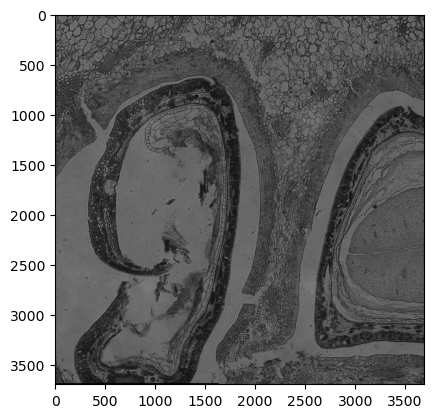

In [16]:
# stitching
result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = images.shape[1]
size_x = images.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image = np.zeros_like(images, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = images[i]

plt.imshow(stitched_image, cmap='grey')